In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
ROOT_PATH = Path().absolute().parent.parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
from frequency_response import FrequencyResponse
from legacy_frequency_response import LegacyFrequencyResponse
from peq import PEQ, OptimizationHistory, OptimizationFinished
from constants import DEFAULT_FS, PEQ_CONFIGS

In [26]:
np.argmax([0.0, 0.0, 3.0, 0.0])

2

In [48]:
def plot_loss(time, loss, avg, fig=None, ax=None):
    time = np.array(time)
    loss = np.array(loss)
    if fig is None:
        fig, ax = plt.subplots()
        fig.set_size_inches(15, 8)
    ax.minorticks_on()
    ax.grid(which='both')
    ax.set_ylabel('dB')
    ax.set_xlabel('Time (s)')
    ax.plot(time, loss, label='Loss (dB)')
    ax.set_ylim([None, None])
    ix = np.argmax(change != 0.0) + 1
    print(ix)
    ax.plot(time[ix:], avg[ix:], label='Avg')
    ax.legend()
    return fig, ax

In [46]:
def rmse(fr, eq):
    ix10k = np.argmin(np.abs(10000 - fr.frequency))
    return np.sqrt(np.mean(np.square(fr.equalization[:ix10k] - eq[:ix10k])))

Maximum time reached
9


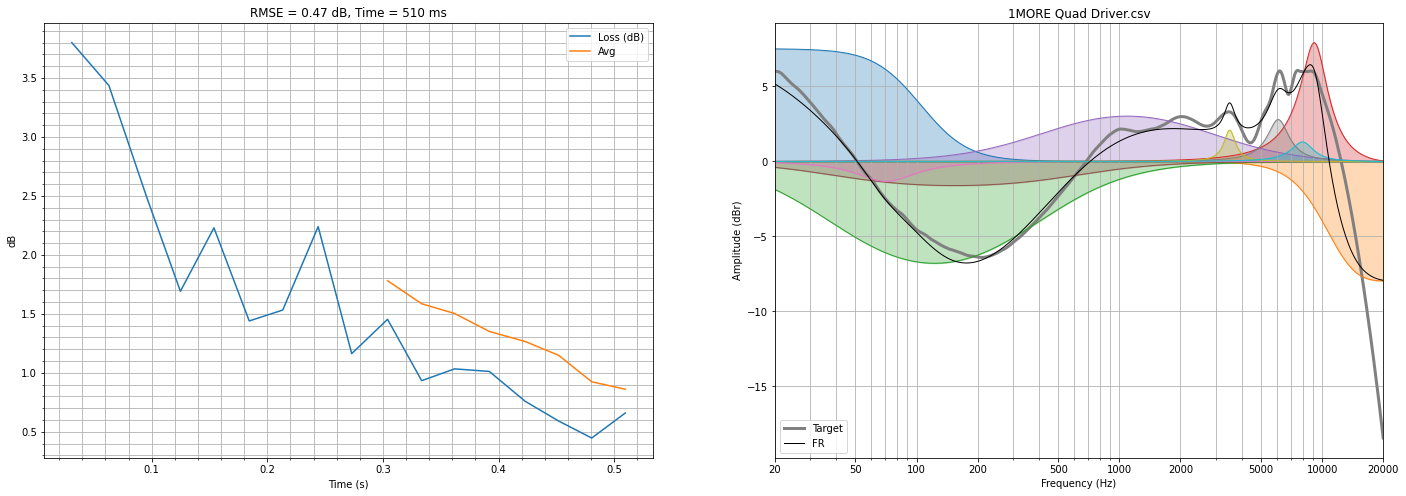

Maximum time reached
9


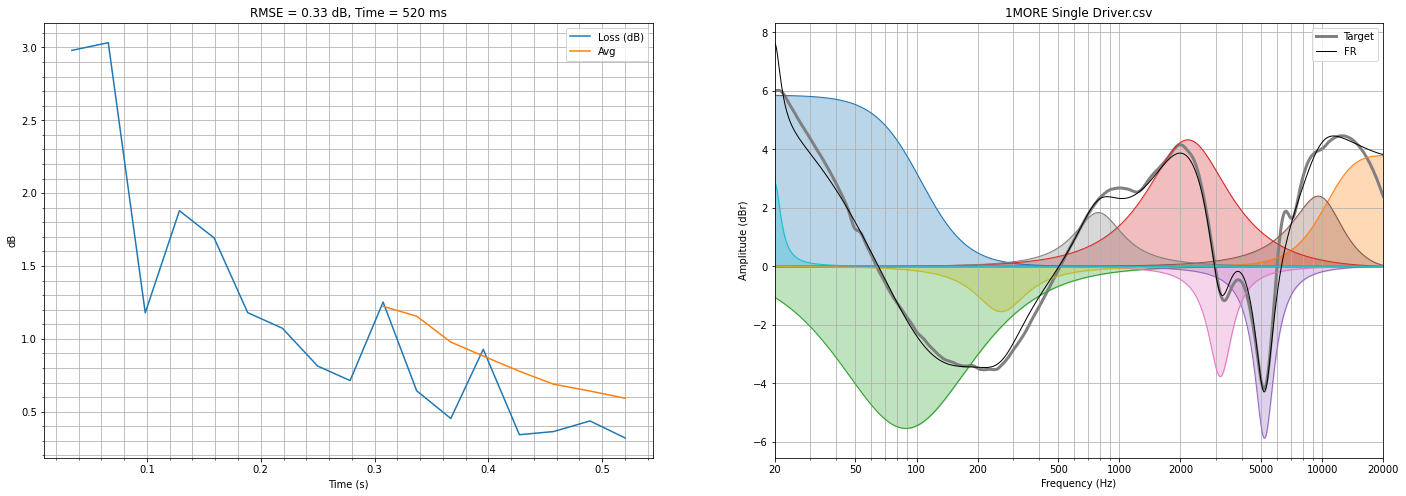

Maximum time reached
9


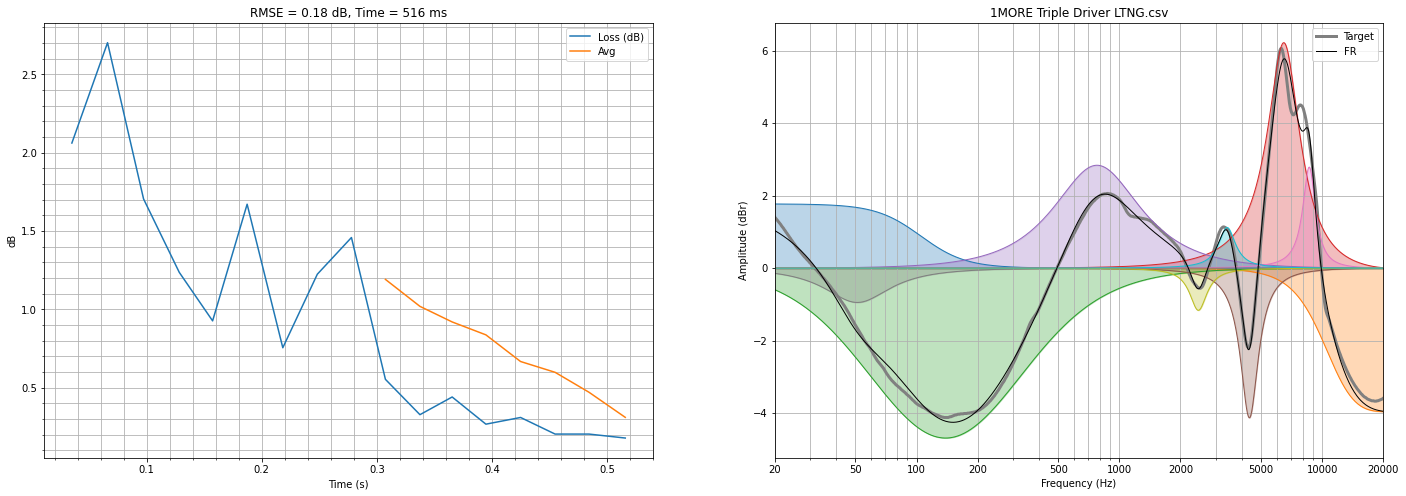

Maximum time reached
9


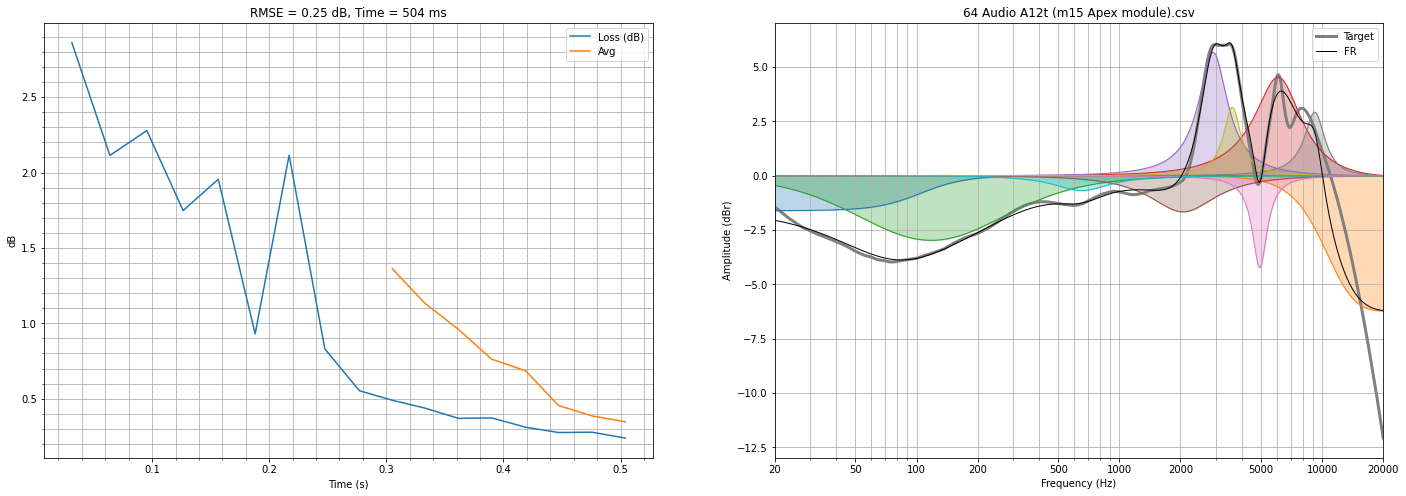

Maximum time reached
9


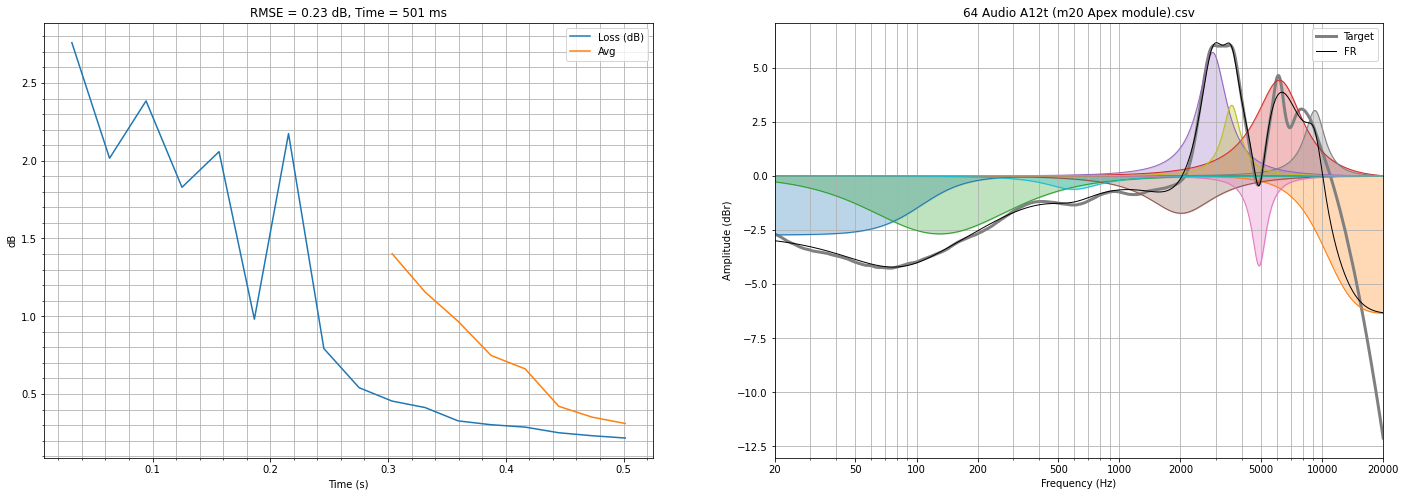

In [49]:
n = 0
for fp in ROOT_PATH.joinpath('results', 'oratory1990').glob('*/*/*.csv'):
    fr = FrequencyResponse.read_from_csv(fp)
    peqs = fr.optimize_parametric_eq(
        [PEQ_CONFIGS['4_PEAKING_WITH_LOW_SHELF'], PEQ_CONFIGS['4_PEAKING_WITH_HIGH_SHELF']],
        #PEQ_CONFIGS['8_PEAKING_WITH_SHELVES'],
        DEFAULT_FS, max_time=0.5, min_change=0.3, target_loss=0.1)
    times = []
    losses = []
    avgs = []
    for peq in peqs:
        times.append(np.array(peq.history.time))
        losses.append(np.array(peq.history.loss))
        avgs.append(np.array(peq.history.moving_avg_loss))
        if len(times) > 1:
            times[-1] += times[-2][-1]
    t = np.concatenate(times)
    loss = np.concatenate(losses)
    avg = np.concatenate(avgs)
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(24, 8)
    plot_loss(t, loss, avg, fig=fig, ax=axs[0])
    if len(peqs) > 1:
        for i in range(1, len(peqs)):
            for filt in peqs[i].filters:
                peqs[0].add_filter(filt)
    FrequencyResponse.init_plot(fig=fig, ax=axs[1])
    peqs[0].plot(fig=fig, ax=axs[1])
    axs[0].set_title(f'RMSE = {rmse(fr, peqs[0].fr):.2f} dB, Time = {np.sum([peq.history.time[-1] for peq in peqs]) * 1000:.0f} ms')
    axs[1].set_title(f'{fp.name}')
    plt.show()
    n += 1
    if n == 5:
        break